<a href="https://colab.research.google.com/github/sdgroeve/D012554_Machine_Learning_2023/blob/main/01_logisitc_regression_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import requests
from pathlib import Path 

request = requests.get("https://raw.githubusercontent.com/sdgroeve/D012554_Machine_Learning_2023/main/utils/utils.py")
with open("utils.py", "wb") as f:
  f.write(request.content)

from utils import plot_decision_boundary

In [109]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Logitic regression in PyTorch


[PyTorch](https://pytorch.org/) is an open source deep learning framework. 

In this notebook we will learn about a PyTorch training and evaluation workflow for fitting a logistic regression model on a toy dataset.

First, we import the required PyTorch libraries and fix the random seed.

In [110]:
import torch
from torch import nn 

torch.manual_seed(46)

# Check PyTorch version
torch.__version__

'1.13.1+cu116'

A tyical PyTorch workflow involves:

- Preparing the data
- Building the model
- Fitting the model to the data (training)
- Computing predictions and evaluating the model
- Saving the model

Let's discuss these steps in more detail by fitting a logistic regression model.

## Preparing the data

The dataset is in a flat file called `dataset_logistic_regression.csv`. 

We read this file into a Pandas DataFrame.

In [111]:
import pandas as pd

data_path = "https://raw.githubusercontent.com/sdgroeve/D012554_Machine_Learning_2023/main/datasets/dataset_logistic_regression.csv"

dataset = pd.read_csv(data_path)

dataset.head()

,x_1,x_2,y
0,0.716568,-1.039137,1
1,0.690542,-1.502750,1
2,-0.005533,-1.093649,1
3,-0.857466,0.420568,0
4,-1.305446,1.366230,0


The dataset as two features `x_1` and `x_2`, and one label `y`. 

Let's plot this data. 

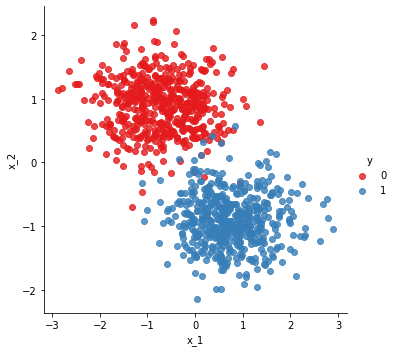

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(x="x_1",y="x_2",hue="y",data=dataset,fit_reg=False, palette="Set1")
plt.show()

We put the feature columns in a DataFrame called `X` and the label column in a DataFrame (or Series) called `y`.

In [113]:
y = dataset.pop('y')
X = dataset

A typical deep learning workflow would involve a train, a validation and a test split of the dataset. 

The train set is used to fit the modelparameters. 

The validation set is used to evaluate different hyperparameter values. 

The test set is used to estimate the exppected prediction error on unseen external data. The data in the test set should not be used of training the network, nor for evaluating different hyperparameter values.

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(800, 2)
(100, 2)
(100, 2)


In PyTorch we work with tensor representaions of the dataset. A PyTorch Tensor is basically the same as a numpy array, it does not know anything about deep learning or computational graphs or gradients, and is just a generic n-dimensional array optimized for arbitrary numeric computation.

To create a tensor we need to first extract the numpy data from the Pandas DataFrames.

In [115]:
type(X_train)

pandas.core.frame.DataFrame

In [116]:
X_train, X_val, X_test = X_train.values, X_val.values, X_test.values
y_train, y_val, y_test = y_train.values, y_val.values, y_test.values

In [117]:
type(X_train)

numpy.ndarray

Now we can create the Tensors.

In [118]:
X_train, X_val, X_test = torch.Tensor(X_train),torch.Tensor(X_val),torch.Tensor(X_test)
y_train, y_val, y_test = torch.Tensor(y_train),torch.Tensor(y_val),torch.Tensor(y_test)

In [119]:
type(X_train)

torch.Tensor

## Building the model

To build a model in PyTorch we need to create a subclass of `torch.nn.Module` such that this subclass inherits all functionality required for fitting our model.

The following code builds a logistic regression model as a class called `LogisticRegression`.

In [120]:
class LogisticRegression(torch.nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()

    self.linear = torch.nn.Linear(input_dim, output_dim)   
    
    torch.nn.init.normal_(self.linear.weight) 
    torch.nn.init.normal_(self.linear.bias) 

  def forward(self, x):
    x = self.linear(x)
    return x

This class implements at least two methods: `__init__()` and `forward()`.

### `__init()__`



In this function we declare all the layers we want to use. For the logistic regression model we need one linear layer `torch.nn.Linear`, which is a single layer feed forward network with `input_dim` inputs and `output_dim` outputs.

The method `__init__()` is called when an instance of our class `LogisticRegression` is created.

In [121]:
# Two inputs x_1 and x_2
input_dim = 2  
# Single binary output 
output_dim = 1 

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model = LogisticRegression(input_dim, output_dim)

We now created a `LogisticRegression` instance called `model` that has three  modelparameters: one for each feature `x_1` and `x_2` (aka weights) and one bias (`x_0`). 

As this class inherits all functionality of the `totch.nn.Module` class, we can now, for instance, call the inherited `.state_dict()` method to get the state (what the model contains) of our model.

In [122]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[-0.2668,  1.5554]])),
             ('linear.bias', tensor([-0.5727]))])

We can access these modelparameters as follows.

In [123]:
model.linear.weight

Parameter containing:
tensor([[-0.2668,  1.5554]], requires_grad=True)

We used `torch.nn.init.uniform_()` to set the initial values of the modelparameters by random sampling from a normal disribution with mean equal to zero and standard deviation equal to one.

The following code plots the initial decision bounday of our model. 

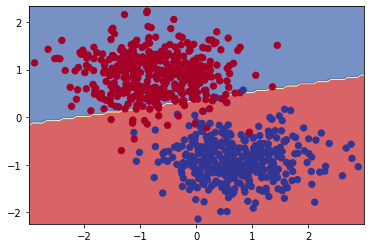

In [124]:
plot_decision_boundary(model, X_train, y_train)

### `forward()`

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined. 

Let's compute predictions for the first 10 feature vectors in the test set.

In [125]:
with torch.inference_mode(): 
    predictions = model(X_test[:10])

predictions

tensor([[-2.1812],
        [-2.3768],
        [-2.8052],
        [-2.1842],
        [ 0.9230],
        [ 2.0400],
        [-2.0212],
        [-1.3535],
        [ 0.5570],
        [-2.3947]])

In [126]:
predictions = torch.sigmoid(predictions)
predictions

tensor([[0.1015],
        [0.0850],
        [0.0570],
        [0.1012],
        [0.7157],
        [0.8849],
        [0.1170],
        [0.2053],
        [0.6358],
        [0.0836]])

In [127]:
predictions = torch.round(predictions)
predictions

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]])

Because we are working with tensors, the model outputs are returned as an array of (1-dimensional) arrays.

In [128]:
print(predictions.shape)

torch.Size([10, 1])


We use the PyTorch method `squeeze()` to reshape this tensor to a 1-dimensional array (The `squeeze()` method removes all dimensions with size 1).

In [129]:
predictions = torch.squeeze(predictions)

predictions

tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 0.])

As with the Pandas example above, we can extract the data as a numpy array.

In [130]:
predictions = predictions.detach().numpy()

predictions

array([0., 0., 0., 0., 1., 1., 0., 0., 1., 0.], dtype=float32)

The Tensor.detach() method is used to detach a tensor from the current computational graph (more about this later). 

We also need to detach a tensor when we need to move the tensor from GPU to CPU.

Now, we can compute evaluation metrics for the predicitons, e.g. the AUC.

In [131]:
from sklearn.metrics import accuracy_score

with torch.inference_mode(): 
    predictions = model(X_test)

predictions = torch.round(torch.sigmoid(torch.squeeze(predictions)))
predictions = predictions.detach().numpy()

print("test set accuracy: {}".format(accuracy_score(y_test,predictions)))

test set accuracy: 0.03


You probably noticed we used [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html) as a [context manager](https://realpython.com/python-with-statement/) (that's what the `with torch.inference_mode():` is) to make the predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the `forward()` method) faster.

## Training the model

Our model is making predictions using random modelparameter values.


For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

To train the model we need to add a **loss function** and an **optimizer**. The loss function measures how wrong the model predictions are compared to the true labels. The optimizer tells your model how to update its modelparameters to best lower the loss.

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems or cross entropy loss function for classification problems, as for our dataset. 

For the optimizer we will SGD, `torch.optim.SGD(params, lr)` where:

* `params` are the modelparameters we want to optimize
* `lr` is the **learning rate** you'd like the optimizer to update the modelparameters at

In [132]:
learning_rate = 0.001

#the loss function
loss_func = torch.nn.BCEWithLogitsLoss()

#the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Now we've got a loss function and an optimizer, it's now time to create a **training loop** (and **validation loop**).

For the training loop, we have to code the following steps:

1. Forward pass: the model goes through all of the training data once, performing its `forward()` function calculations.

2. Calculate the loss: the model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.
3. Zero the gradients: the optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.
4. Perform backpropagation on the loss: computes the gradient of the loss with respect to every modelparameter 
5. Update the optimizer (**gradient descent**): update the modelparameter values with respect to the loss gradients.


0
training loss: 1.8358852863311768
validation accuracy: 0.01


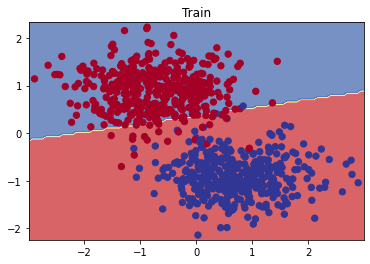

500
training loss: 1.4082454442977905
validation accuracy: 0.05


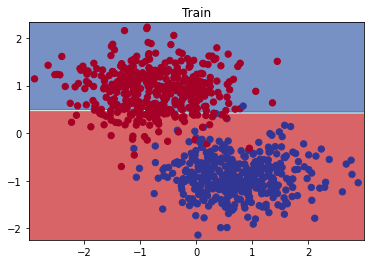

1000
training loss: 1.0780071020126343
validation accuracy: 0.14


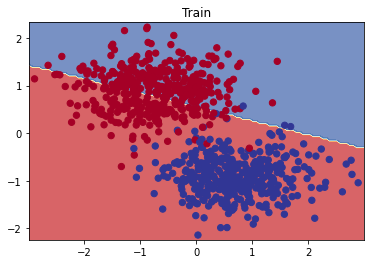

1500
training loss: 0.8399019837379456
validation accuracy: 0.27


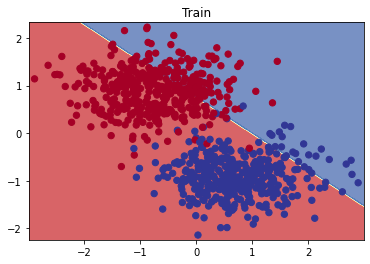

2000
training loss: 0.6738988757133484
validation accuracy: 0.48


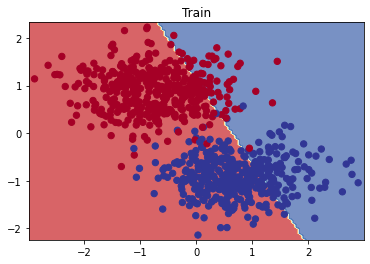

2500
training loss: 0.5580299496650696
validation accuracy: 0.7


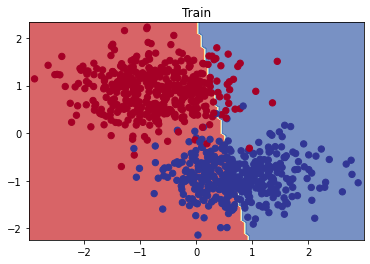

3000
training loss: 0.4753563404083252
validation accuracy: 0.84


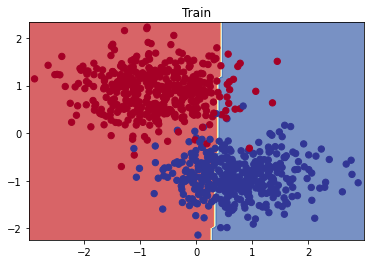

3500
training loss: 0.4145793616771698
validation accuracy: 0.89


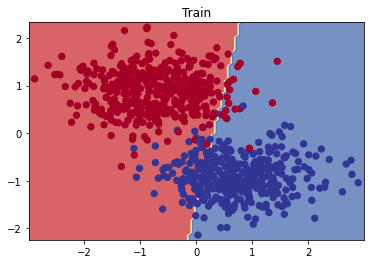

4000
training loss: 0.36851954460144043
validation accuracy: 0.9


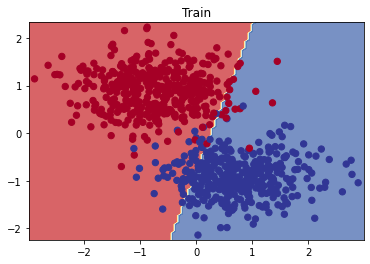

4500
training loss: 0.3326253592967987
validation accuracy: 0.91


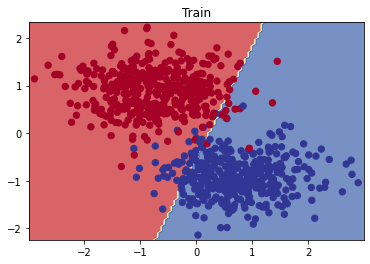

5000
training loss: 0.3039594888687134
validation accuracy: 0.92


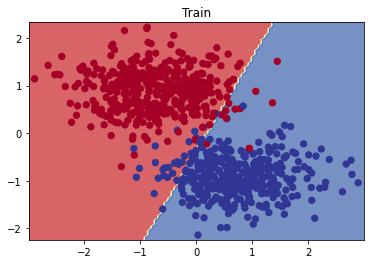

5500
training loss: 0.280577152967453
validation accuracy: 0.95


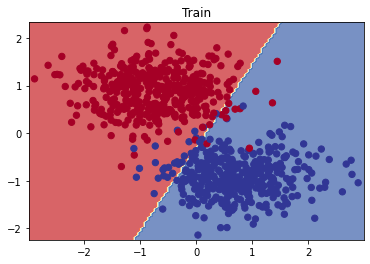

6000
training loss: 0.26115530729293823
validation accuracy: 0.96


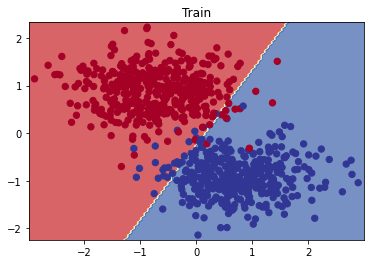

6500
training loss: 0.24476931989192963
validation accuracy: 0.96


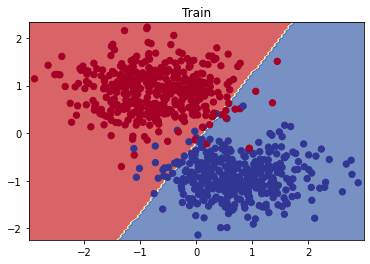

7000
training loss: 0.23075751960277557
validation accuracy: 0.96


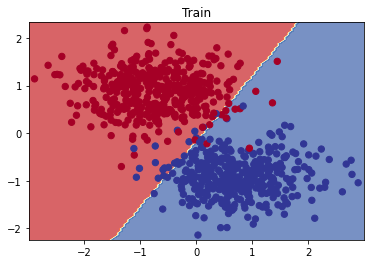

7500
training loss: 0.21863509714603424
validation accuracy: 0.96


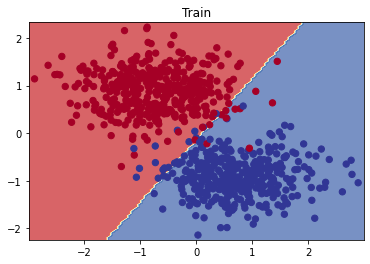

In [133]:
#number of times we iterate trough the train set
num_epochs = 8000

for epoch in range(num_epochs):

    #step 1
    predictions_train = torch.squeeze(model(X_train)) 

    #step 2
    loss = loss_func(predictions_train, y_train) 

    #step 3
    optimizer.zero_grad() 

    #step 4
    loss.backward() 

    #step 5
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
        
    if epoch % 500 == 0:    
      #compute AUC on validation set
      predictions_val = torch.round(torch.sigmoid(torch.squeeze(model(X_val)))).detach().numpy()
      #print(predictions_val)
      print(epoch)
      print("training loss: {}".format(loss))    
      print("validation accuracy: {}".format(accuracy_score(y_val,predictions_val)))
      plt.clf()
      plt.title("Train")
      plot_decision_boundary(model, X_train, y_train)
      plt.show()

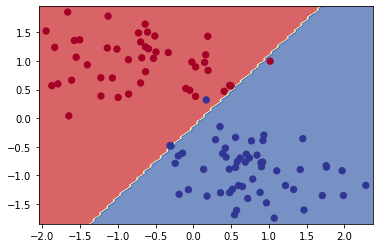

In [134]:
plot_decision_boundary(model, X_val, y_val)


## Computing predictions and evaluating the model


In [135]:
model.eval()

with torch.inference_mode(): 
    predictions_test = model(X_test)

predictions_test = torch.round(torch.sigmoid(torch.squeeze(predictions_test))).detach().numpy()

print("test set accuracy: {}".format(accuracy_score(y_test,predictions_test)))

test set accuracy: 0.97


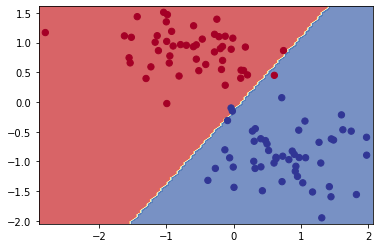

In [136]:
plot_decision_boundary(model, X_test, y_test)


## Saving (and loading) the model

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving a model for inference (making predictions) is by saving the modelparameter values in `state_dict()`.

We call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.


In [137]:
model_filename = "model_logistic_regression.pth"
torch.save(obj=model.state_dict(), f=model_filename) 

To load a model, we first load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).


In [138]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = LogisticRegression(input_dim, output_dim)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=model_filename))

<All keys matched successfully>

Excellent! It looks like things matched up.

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

Remember the rules for performing inference with PyTorch models?

If not, here's a refresher:

<details>
    <summary>PyTorch inference rules</summary>
    <ol>
      <li> Set the model in evaluation mode (<code>model.eval()</code>). </li>
      <li> Make the predictions using the inference mode context manager (<code>with torch.inference_mode(): ...</code>). </li>
      <li> All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).</li>
    </ol> 
</details>



In [139]:
# 1. Put the loaded model into evaluation mode
loaded_model.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test) # perform a forward pass on the test data with the loaded model